# Praktikum Lab 10 Deep Learning INF-A


#Langkah pertama, Setup

In [1]:
# Setup enivronment
# !pip install -q tensorflow numpy matplotlib scikit-learn
import os, random, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
SEED = 123
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)
print(tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU'))>0)

2.19.0
GPU available: True


#Langkah kedua, Load Dataset (imdb)
Dataset: tf.keras.datasets.imdb (50k review, biner).
Fokus: tokenization & padding, arsitektur Embedding → BiLSTM → Dense, regularisasi.
Target hasil: akurasi test ~0.87–0.90 (3–5 epoch cepat).

In [3]:
# --- Load & prep data
vocab_size = 20000
max_len = 200
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=vocab_size)
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

# --- Model: Embedding -> BiLSTM -> Dropout -> Dense
def build_bilstm_model(embed_dim=128, lstm_units=64, dropout=0.3):
    inputs = keras.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, embed_dim, input_length=max_len)(inputs)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

bilstm = build_bilstm_model()
bilstm.summary()

history = bilstm.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=3, batch_size=128, verbose=1
)

test_loss, test_acc = bilstm.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.6326 - loss: 0.6100 - val_accuracy: 0.8596 - val_loss: 0.3384
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8772 - loss: 0.3132 - val_accuracy: 0.8610 - val_loss: 0.3484
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9216 - loss: 0.2141 - val_accuracy: 0.8786 - val_loss: 0.3617
Test accuracy: 0.865


Variasi cepat (opsional 5–7 menit):

• Ganti max_len 100 vs 300 ➜ lihat dampaknya (kecepatan vs konteks).

• Tambahkan layers.SpatialDropout1D(0.2) tepat setelah Embedding untuk
regularisasi sekuens.

In [4]:
# Variasi cepat (opsional 5–7 menit):
# • Ganti max_len 100 vs 300 dan lihat dampaknya (kecepatan vs konteks).
# • Tambahkan layers.SpatialDropout1D(0.2) tepat setelah Embedding untuk regularisasi sekuens.

import time
from tensorflow import keras
from tensorflow.keras import layers

vocab_size = 20000
# default_max_len tidak digunakan langsung oleh eksperimen — lihat daftar max_lens di main()
default_max_len = 200

def build_bilstm_model(max_len, embed_dim=128, lstm_units=64, dropout=0.3):
    inputs = keras.Input(shape=(max_len,))
    x = layers.Embedding(vocab_size, embed_dim, input_length=max_len)(inputs)
    # SpatialDropout1D untuk regularisasi sekuens tepat setelah embedding
    x = layers.SpatialDropout1D(0.2)(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def run_experiment(max_len, epochs=3, batch_size=128, verbose=1):
    print(f"\n--- Running experiment with max_len = {max_len} ---")
    # Load & prep data
    (x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=vocab_size)
    x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
    x_test  = keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=max_len)

    model = build_bilstm_model(max_len=max_len)
    model.summary()

    start_time = time.time()
    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        epochs=epochs, batch_size=batch_size, verbose=verbose
    )
    elapsed = time.time() - start_time

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f"max_len={max_len} -> Test accuracy: {test_acc:.3f}, Test loss: {test_loss:.3f}")
    print(f"Training time (seconds): {elapsed:.1f}")
    return {
        "max_len": max_len,
        "test_acc": float(test_acc),
        "test_loss": float(test_loss),
        "train_time_s": float(elapsed),
        "history": history.history
    }

if __name__ == "__main__":
    # Jalankan variasi singkat: 100 dan 300
    results = []
    for ml in [100, 300]:
        res = run_experiment(max_len=ml, epochs=3, batch_size=128, verbose=1)
        results.append(res)

    print("\nSummary of runs:")
    for r in results:
        print(f" max_len={r['max_len']}: acc={r['test_acc']:.3f}, loss={r['test_loss']:.3f}, time={r['train_time_s']:.1f}s")


--- Running experiment with max_len = 100 ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 100, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6562 - loss: 0.5892 - val_accuracy: 0.8488 - val_loss: 0.3542
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8830 - loss: 0.2874 - val_accuracy: 0.8490 - val_loss: 0.3727
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9304 - loss: 0.1947 - val_accuracy: 0.8142 - val_loss: 0.5445
max_len=100 -> Test accuracy: 0.809, Test loss: 0.576
Training time (seconds): 10.6

--- Running experiment with max_len = 300 ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 300, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 300, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,658,945 (10.14 MB)

 Trainable params: 2,658,945 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6256 - loss: 0.6183 - val_accuracy: 0.8276 - val_loss: 0.3994
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8673 - loss: 0.3191 - val_accuracy: 0.8562 - val_loss: 0.3350
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9266 - loss: 0.2006 - val_accuracy: 0.8530 - val_loss: 0.4625
max_len=300 -> Test accuracy: 0.837, Test loss: 0.517
Training time (seconds): 19.1

Summary of runs:
 max_len=100: acc=0.809, loss=0.576, time=10.6s
 max_len=300: acc=0.837, loss=0.517, time=19.1s


#Langkah Ketiga, Time series LSTM
Dataset: synthetic sin wave + noise (bisa selesai cepat), supervised framing dengan sliding
window.
Fokus: bentuk input (batch, timesteps, features), sequence-to-one.

Target hasil: MAE kecil (<0.10) dalam beberapa epoch.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4907 - val_loss: 0.2000
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1492 - val_loss: 0.0937
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1096 - val_loss: 0.0869
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1052 - val_loss: 0.0891
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1028 - val_loss: 0.0853
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1036 - val_loss: 0.0927
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1015 - val_loss: 0.0879
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1024 - val_loss: 0.0884
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0998 - val_loss: 0.0857
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1015 - val_loss: 0.0858
Test MAE: 0.09026512503623962


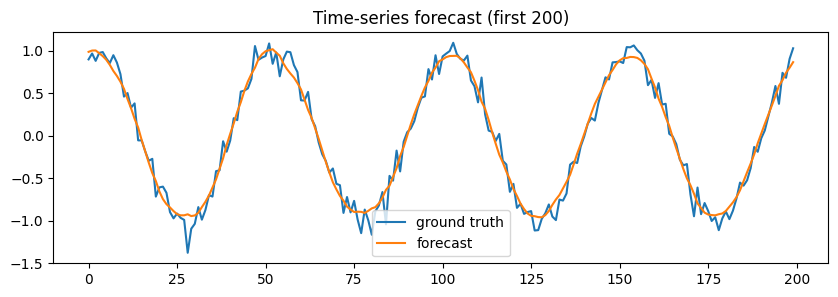

In [5]:
# --- Generate synthetic data: sin + noise
T = 2000; steps = np.arange(T)
signal = np.sin(2*np.pi*steps/50) + 0.1*np.random.randn(T)
# --- framing function: window -> next value
def make_dataset(series, window=50):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    X = np.array(X)[:, :, np.newaxis]
    # (N, window, 1)
    y = np.array(y)
    return X, y
WINDOW = 50
X, y = make_dataset(signal, window=WINDOW)
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test,  y_test  = X[split:], y[split:]
# --- Model LSTM sederhana
def build_ts_lstm(units=64, dropout=0.2):
    model = keras.Sequential([
        layers.Input(shape=(WINDOW,1)),
        layers.LSTM(units),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mae")
    return model
ts_model = build_ts_lstm()
ts_model.summary()
hist = ts_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10, batch_size=64, verbose=1
)
mae = ts_model.evaluate(X_test, y_test, verbose=0)
print("Test MAE:", mae)
# --- Visual check
pred = ts_model.predict(X_test, verbose=0).squeeze()
plt.figure(figsize=(10,3))
plt.plot(y_test[:200], label="ground truth")
plt.plot(pred[:200], label="forecast")
plt.legend(); plt.title("Time-series forecast (first 200)")
plt.show()

Variasi (opsional 5 menit):

• Tambah layers.LSTM(units, return_sequences=True) + layers.LSTM(units)
(2 layer).

• Ubah WINDOW (25 vs 100) ➜ diskusi trade-off.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 25, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.5303 - val_loss: 0.1404
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1297 - val_loss: 0.0924
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1138 - val_loss: 0.0853
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1071 - val_loss: 0.0904
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1075 - val_loss: 0.0880
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1015 - val_loss: 0.0932
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1102 - val_loss: 0.1049
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1069 - val_loss: 0.0888
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0992 - val_loss: 0.0919
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1017 - val_loss: 0.0894

WINDOW=25 -> Test MAE: 0.0885, training time: 4.3s


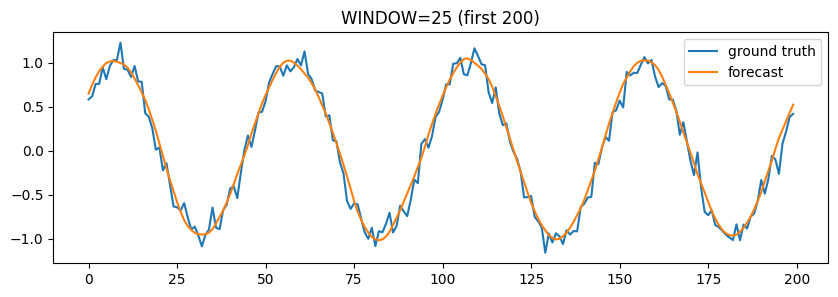

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.4917 - val_loss: 0.1023
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1309 - val_loss: 0.0961
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1094 - val_loss: 0.0820
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0994 - val_loss: 0.0856
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1045 - val_loss: 0.0852
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1034 - val_loss: 0.0893
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0993 - val_loss: 0.0897
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0984 - val_loss: 0.0836
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0939 - val_loss: 0.0857
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0938 - val_loss: 0.0881

WINDOW=100 -> Test MAE: 0.0903, training time: 5.2s


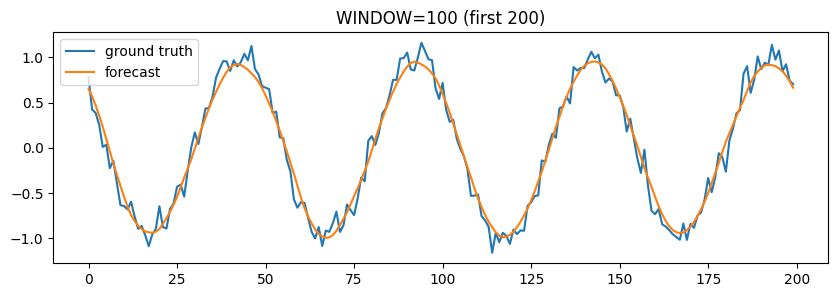


Summary:
 WINDOW=25: MAE=0.0885, time=4.3s
 WINDOW=100: MAE=0.0903, time=5.2s


In [6]:
# Variasi: 2-layer LSTM (return_sequences=True pada layer pertama) + eksperimen WINDOW 25 vs 100
# import time
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow import keras
# from tensorflow.keras import layers

# --- Generate synthetic data: sin + noise
T = 2000; steps = np.arange(T)
signal = np.sin(2*np.pi*steps/50) + 0.1*np.random.randn(T)

# --- framing function: window -> next value
def make_dataset(series, window=50):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    X = np.array(X)[:, :, np.newaxis]   # (N, window, 1)
    y = np.array(y)
    return X, y

def build_ts_lstm(window, units=64, dropout=0.2):
    model = keras.Sequential([
        layers.Input(shape=(window,1)),
        # Layer pertama: mengembalikan seluruh sequence untuk layer LSTM berikutnya
        layers.LSTM(units, return_sequences=True),
        # Layer kedua: menghaluskan menjadi output vektor terakhir
        layers.LSTM(units),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mae")
    return model

def run_for_window(WINDOW, epochs=10, batch_size=64, verbose=1):
    X, y = make_dataset(signal, window=WINDOW)
    split = int(0.8 * len(X))
    X_train, y_train = X[:split], y[:split]
    X_test,  y_test  = X[split:], y[split:]

    model = build_ts_lstm(window=WINDOW)
    model.summary()

    start = time.time()
    hist = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs, batch_size=batch_size, verbose=verbose
    )
    elapsed = time.time() - start

    mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nWINDOW={WINDOW} -> Test MAE: {mae:.4f}, training time: {elapsed:.1f}s")
    # Visual check (first 200)
    pred = model.predict(X_test, verbose=0).squeeze()
    plt.figure(figsize=(10,3))
    plt.plot(y_test[:200], label="ground truth")
    plt.plot(pred[:200], label="forecast")
    plt.legend(); plt.title(f"WINDOW={WINDOW} (first 200)")
    plt.show()

    return {"window": WINDOW, "mae": float(mae), "train_time_s": float(elapsed), "history": hist.history}

if __name__ == "__main__":
    results = []
    for W in [25, 100]:
        res = run_for_window(WINDOW=W, epochs=10, batch_size=64, verbose=1)
        results.append(res)

    print("\nSummary:")
    for r in results:
        print(f" WINDOW={r['window']}: MAE={r['mae']:.4f}, time={r['train_time_s']:.1f}s")

#Langkah keempat, Computer Vision
Dataset: tf.keras.datasets.cifar10 (60k gambar 32×32×3, 10 kelas).
Fokus: efek BatchNorm pada konvergensi dan akurasi; arsitektur identik selain lapisan BN.

Target hasil (3 epoch cepat):

• No-BN: val acc ~0.68–0.72

• With BN: val acc ~0.73–0.78
(hasil bervariasi tergantung GPU/time)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.3558 - loss: 1.7780 - val_accuracy: 0.5506 - val_loss: 1.2647
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5782 - loss: 1.1776 - val_accuracy: 0.6439 - val_loss: 1.0155
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6646 - loss: 0.9493 - val_accuracy: 0.6860 - val_loss: 0.9069
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - accuracy: 0.4981 - loss: 1.4139 - val_accuracy: 0.3424 - val_loss: 2.1368
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7082 - loss: 0.8310 - val_accuracy: 0.5637 - val_loss: 1.3402
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7794 - loss: 0.6362 - val_accuracy: 0.5679 - val_loss: 1.3185
No-BN Test: [0.9236278533935547, 0.6758000254631042]
With-BN Test: [1.3247835636138916, 0.5691999793052673]


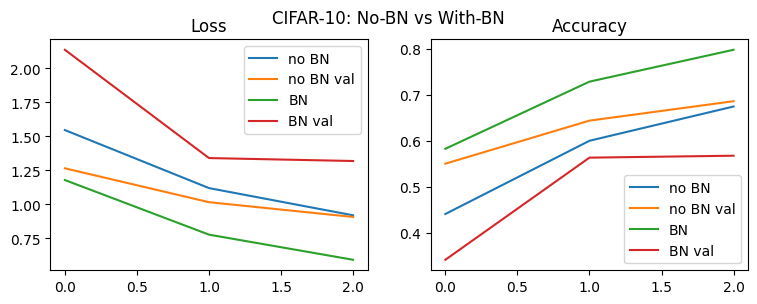

In [8]:
# --- Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
num_classes = 10
x_train = x_train.astype("float32")/255.0
x_test  = x_test.astype("float32")/255.0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)
# --- Arsitektur baseline (tanpa BN)
def build_cnn_no_bn():
    inputs = keras.Input(shape=(32,32,3))
    x = layers.Conv2D(32,3,padding="same")(inputs); x = layers.ReLU()(x)
    x = layers.Conv2D(32,3,padding="same")(x);     x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,padding="same")(x); x = layers.ReLU()(x)
    x = layers.Conv2D(64,3,padding="same")(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model
# --- Arsitektur identik + BatchNorm setelah tiap Conv
def build_cnn_bn():
    inputs = keras.Input(shape=(32,32,3))
    x = layers.Conv2D(32,3,padding="same")(inputs); x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(32,3,padding="same")(x);     x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,padding="same")(x); x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(64,3,padding="same")(x); x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128)(x); x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model
no_bn = build_cnn_no_bn()
with_bn = build_cnn_bn()
# --- Train singkat (3 epoch) untuk perbandingan cepat
hist_no_bn = no_bn.fit(x_train, y_train, validation_split=0.2, epochs=3,
                       batch_size=128, verbose=1)
hist_bn    = with_bn.fit(x_train, y_train, validation_split=0.2, epochs=3,
                        batch_size=128, verbose=1)
print("No-BN Test:", no_bn.evaluate(x_test, y_test, verbose=0))
print("With-BN Test:", with_bn.evaluate(x_test, y_test, verbose=0))
# --- Plot loss/accuracy komparatif
def plot_hist(h1, h2, title):
    plt.figure(figsize=(9,3))
    plt.subplot(1,2,1); plt.plot(h1.history["loss"], label="no BN");
    plt.plot(h1.history["val_loss"], label="no BN val")
    plt.plot(h2.history["loss"], label="BN");
    plt.plot(h2.history["val_loss"], label="BN val"); plt.title("Loss");
    plt.legend()
    plt.subplot(1,2,2); plt.plot(h1.history["accuracy"], label="no BN");
    plt.plot(h1.history["val_accuracy"], label="no BN val")
    plt.plot(h2.history["accuracy"], label="BN");
    plt.plot(h2.history["val_accuracy"], label="BN val");
    plt.title("Accuracy"); plt.legend()
    plt.suptitle(title); plt.show()
plot_hist(hist_no_bn, hist_bn, "CIFAR-10: No-BN vs With-BN")

Eksperimen singkat (opsional 5–7 menit):

• Coba batch_size=32 vs 256 ➜ perhatikan stabilitas BN (mini-batch terlalu kecil
sering tak stabil).

• Tambah Dropout(0.3) di Dense: lihat trade-off regularisasi vs konvergensi.


--- Running: batch_size=32, dropout_dense=0.0 ---


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,554 (2.26 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5129 - loss: 1.3671 - val_accuracy: 0.6563 - val_loss: 0.9802
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7232 - loss: 0.8005 - val_accuracy: 0.7170 - val_loss: 0.8000
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7914 - loss: 0.6013 - val_accuracy: 0.7034 - val_loss: 0.8841
Result -> batch_size=32, dropout_dense=0.0: Test loss=0.8977, Test acc=0.6991, time=28.7s


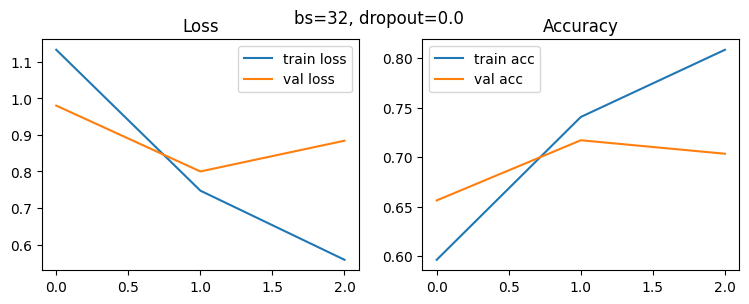


--- Running: batch_size=32, dropout_dense=0.3 ---


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,554 (2.26 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.4710 - loss: 1.5041 - val_accuracy: 0.6275 - val_loss: 1.0626
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6779 - loss: 0.9187 - val_accuracy: 0.6637 - val_loss: 0.9414
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7366 - loss: 0.7527 - val_accuracy: 0.6853 - val_loss: 0.9190
Result -> batch_size=32, dropout_dense=0.3: Test loss=0.9168, Test acc=0.6883, time=33.9s


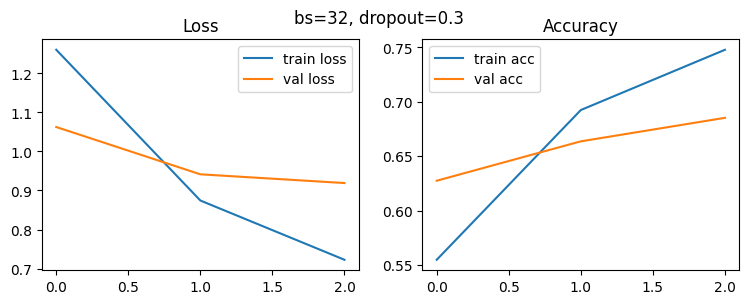


--- Running: batch_size=256, dropout_dense=0.0 ---


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_21 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_22 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_23 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,554 (2.26 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.4689 - loss: 1.5171 - val_accuracy: 0.1370 - val_loss: 2.8970
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6943 - loss: 0.8799 - val_accuracy: 0.3339 - val_loss: 2.0164
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7731 - loss: 0.6690 - val_accuracy: 0.5630 - val_loss: 1.2805
Result -> batch_size=256, dropout_dense=0.0: Test loss=1.2626, Test acc=0.5699, time=23.8s


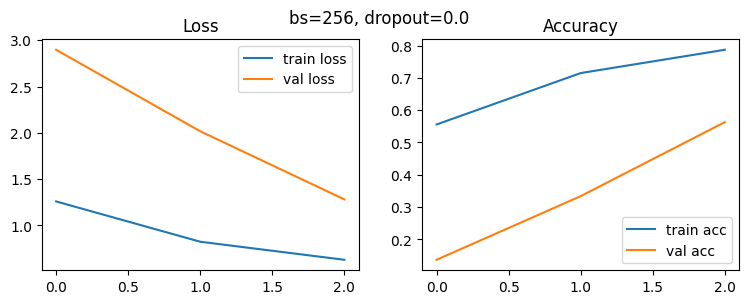


--- Running: batch_size=256, dropout_dense=0.3 ---


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_24 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_26 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_27 (ReLU)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_28 (ReLU)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,554 (2.26 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.4346 - loss: 1.6300 - val_accuracy: 0.1343 - val_loss: 3.4713
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6576 - loss: 0.9797 - val_accuracy: 0.2796 - val_loss: 2.4223
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7248 - loss: 0.7890 - val_accuracy: 0.5368 - val_loss: 1.3970
Result -> batch_size=256, dropout_dense=0.3: Test loss=1.3734, Test acc=0.5409, time=24.1s


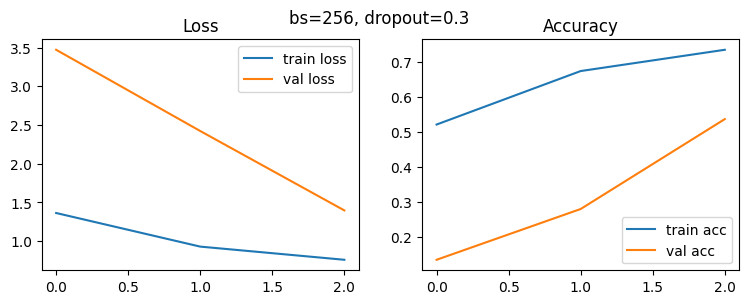


Summary of all runs:
 bs=32, dropout=0.0: acc=0.6991, loss=0.8977, time=28.7s
 bs=32, dropout=0.3: acc=0.6883, loss=0.9168, time=33.9s
 bs=256, dropout=0.0: acc=0.5699, loss=1.2626, time=23.8s
 bs=256, dropout=0.3: acc=0.5409, loss=1.3734, time=24.1s


In [9]:
# Eksperimen singkat: batch_size 32 vs 256 dan Dropout(0.3) pada Dense
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# --- Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
num_classes = 10
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# --- Model builder: identical architecture with BatchNorm after each Conv
def build_cnn_bn(dropout_dense=0.0):
    inputs = keras.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(32, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Optional dropout on Dense block (experiment)
    if dropout_dense and dropout_dense > 0.0:
        x = layers.Dropout(dropout_dense)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def plot_hist(h, title):
    plt.figure(figsize=(9,3))
    plt.subplot(1,2,1)
    plt.plot(h.history["loss"], label="train loss")
    plt.plot(h.history["val_loss"], label="val loss")
    plt.title("Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h.history["accuracy"], label="train acc")
    plt.plot(h.history["val_accuracy"], label="val acc")
    plt.title("Accuracy")
    plt.legend()
    plt.suptitle(title)
    plt.show()

if __name__ == "__main__":
    experiments = []
    batch_sizes = [32, 256]
    dropouts = [0.0, 0.3]  # 0.0 = no dropout in dense, 0.3 = add Dropout(0.3)

    for bs in batch_sizes:
        for dp in dropouts:
            print(f"\n--- Running: batch_size={bs}, dropout_dense={dp} ---")
            model = build_cnn_bn(dropout_dense=dp)
            model.summary()

            start = time.time()
            hist = model.fit(
                x_train, y_train,
                validation_split=0.2,
                epochs=3,
                batch_size=bs,
                verbose=1
            )
            elapsed = time.time() - start

            test_metrics = model.evaluate(x_test, y_test, verbose=0)
            test_loss, test_acc = test_metrics[0], test_metrics[1]
            print(f"Result -> batch_size={bs}, dropout_dense={dp}: Test loss={test_loss:.4f}, Test acc={test_acc:.4f}, time={elapsed:.1f}s")

            experiments.append({
                "batch_size": bs,
                "dropout_dense": dp,
                "test_loss": float(test_loss),
                "test_acc": float(test_acc),
                "train_time_s": float(elapsed),
                "history": hist.history
            })

            # optional quick plot
            plot_hist(hist, f"bs={bs}, dropout={dp}")

    # Summary
    print("\nSummary of all runs:")
    for e in experiments:
        print(f" bs={e['batch_size']}, dropout={e['dropout_dense']}: acc={e['test_acc']:.4f}, loss={e['test_loss']:.4f}, time={e['train_time_s']:.1f}s")

#Langkah kelima, Demonstrasi Inference Mode untuk BatchNorm
Tujuan: pahami perbedaan train vs inference pada BN. Di Keras, ini otomatis, tapi kita bisa
memaksa inference pass pada batch kecil untuk melihat konsistensinya.

In [10]:

# Ambil sejumlah kecil sampel test
small = x_test[:32]
# Prediksi normal (model sudah dalam mode inference saat .predict)
p1 = with_bn.predict(small, verbose=0)
# Prediksi manual dengan training=True (memakai batch-stat saat inference) hanya untuk demo
# (Di Keras: panggil model(small, training=True))
p2 = with_bn(small, training=True).numpy()
# Bandingkan deviasi rata-rata
print("Mean abs diff BN (inference vs training=True):", np.mean(np.abs(p1 -
p2)))

Mean abs diff BN (inference vs training=True): 0.06543441
